# Garbage Classification Using Multimodal Deep Learning

##### Team Members: Rowan (Yi-Kai) Chen, Das (Shih Ting) Tai, Ryan Lau, Zain Jelani
#####Group Number: 16

# ENSF 617 - Assignment 02: Garbage Classification Model
### Group 16
**Team Members:** Rowan (Yi-Kai) Chen, Das (Shih Ting) Tai, Ryan Lau, Zain Jelani  
**Date:** February 26 2026

---

## 1. Project Overview
The objective of this assignment is to develop a deep learning model capable of classifying garbage items into four distinct categories: **Black, Blue, Green, and TTR (Other)**. 

## 2. System Architecture: Late Fusion Approach
Our model implement two backbone architectures:

* **Vision Branch (ResNet50):** A pre-trained Residual Network is used to extract features (2048-d) from the input images.
* **Language Branch (BERT):** A pre-trained `bert-base-uncased` model processes the text descriptions to capture semantic meaning.
* **Fusion Head:** The features from both branches are concatenated into a **2816-dimensional vector** and passed through a series of Fully Connected layers with **Dropout (0.3)** to produce the final classification.


---

## 3. Import & Configuration

In [1]:
import os
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
from torchvision import models, transforms
from torch.utils.data import Dataset, DataLoader
from transformers import BertModel, BertTokenizer
from sklearn.metrics import classification_report, confusion_matrix

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
base_path = './garbage_data'
model_path = "multimodal_garbage_model_251638.pth"
classes = ['Black', 'Blue', 'Green', 'TTR']

# Image Preprocessing for Evaluation
test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

## 4. Dataset Class
  - Handles data loading for images and text.
  - Extracts text labels from filenames (Image-Text pairing).
  - Implements __getitem__ for on-the-fly BERT tokenization and image transformation.

In [2]:
class GarbageMultimodalDataset(Dataset):
    def __init__(self, root_dir, split='Test', transform=None):
        self.transform = transform
        self.target_dir = os.path.join(root_dir, f'CVPR_2024_dataset_{split}')
        self.classes = ['Black', 'Blue', 'Green', 'TTR']
        self.data = []
        self.tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

        if not os.path.exists(self.target_dir):
            print(f"Error: Directory {self.target_dir} not found!")
            return

        for label, cls_name in enumerate(self.classes):
            cls_path = os.path.join(self.target_dir, cls_name)
            if not os.path.exists(cls_path): continue

            for img_name in os.listdir(cls_path):
                if img_name.lower().endswith(('.png', '.jpg', '.jpeg')):
                    img_full_path = os.path.join(cls_path, img_name)
                    # Extract description: "bear_spray_451.png" -> "bear spray"
                    # We remove the trailing ID numbers and extension
                    description = img_name.split('.')[0]
                    description = ''.join([i for i in description if not i.isdigit()]).replace('_', ' ').strip()
                    if not description: description = "garbage item"
                    self.data.append((img_full_path, description, label))

        print(f"Successfully loaded {len(self.data)} samples for {split} set.")

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_path, desc, label = self.data[idx]

        # Image processing
        image = Image.open(img_path).convert('RGB')
        if self.transform:
            image = self.transform(image)

        # Text processing (BERT Tokenization)
        tokens = self.tokenizer(desc, padding='max_length', max_length=16,
                                truncation=True, return_tensors="pt")

        return {
            'image': image,
            'input_ids': tokens['input_ids'].squeeze(),
            'attention_mask': tokens['attention_mask'].squeeze(),
            'label': torch.tensor(label, dtype=torch.long)
        }

## 5. Model Architecture
For this project, we make use of a Late Fusion Approach. This consists of three main components:
- Image Branch:
  - Pre-trained on ResNet50.
  - Outputs 2048 dimensional feature vector from the input images.
  - Backbone frozen to prevent overfitting.
- Text Branch:
  - Pre-trained on BERT.
  - Model processes text descriptions to capture semantic meaning.
- Fusion Head:
  - Image and text features are concatenated into a 2816 dimensional vector.
  - Passed through fully connected layers for final final multimodal classification:
    - Linear layer (512 units)
    - ReLU activation
    - Dropout (0.3)
    - Final linear layer with 4 output classes

In [3]:
class MultimodalClassifier(nn.Module):
    def __init__(self, num_classes=4):
        super(MultimodalClassifier, self).__init__()
        
        # Image branch: ResNet50
        self.resnet = models.resnet50(pretrained=True)
        # Remove the final FC layer to get a 2048-d feature vector
        in_features_img = self.resnet.fc.in_features
        self.resnet.fc = nn.Identity() 
        
        # Text branch: BERT
        self.bert = BertModel.from_pretrained('bert-base-uncased')
        in_features_text = 768 # BERT base hidden size
        
        # Multimodal Classification Head
        self.classifier = nn.Sequential(
            nn.Linear(in_features_img + in_features_text, 512),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(512, num_classes)
        )

    def forward(self, image, input_ids, attention_mask):
        # Extract features from image
        img_features = self.resnet(image) # [Batch, 2048]
        
        # Extract features from text
        text_outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        text_features = text_outputs.pooler_output # [Batch, 768]
        
        # Concatenate image and text features
        combined_features = torch.cat((img_features, text_features), dim=1)
        
        # Final prediction
        return self.classifier(combined_features)

## 6. Evaluation
To evaluate the trained model:
- Ensure the trained model file exists:
  - multimodal_garbage_model_251638.pth
- Ensure the dataset path is correctly set in the script.
- Run the evaluation script to perform inference on the test set.

/home/yikai.chen/software/miniforge3/envs/pytorch/lib/python3.14/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/yikai.chen/software/miniforge3/envs/pytorch/lib/python3.14/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading weights:   0%|          | 0/199 [00:00<?, ?it/s]

BertModel LOAD REPORT from: bert-base-uncased
Key                                        | Status     |  | 
-------------------------------------------+------------+--+-
cls.predictions.transform.dense.weight     | UNEXPECTED |  | 
cls.predictions.bias                       | UNEXPECTED |  | 
cls.seq_relationship.weight                | UNEXPECTED |  | 
cls.predictions.transform.LayerNorm.weight | UNEXPECTED |  | 
cls.predictions.transform.dense.bias       | UNEXPECTED |  | 
cls.predictions.transform.LayerNorm.bias   | UNEXPECTED |  | 
cls.seq_relationship.bias                  | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.


Successfully loaded 3432 samples for Test set.

--- Final Classification Report ---
              precision    recall  f1-score   support

       Black       0.67      0.82      0.74       695
        Blue       0.85      0.83      0.84      1086
       Green       0.91      0.92      0.91       799
         TTR       0.91      0.76      0.83       852

    accuracy                           0.83      3432
   macro avg       0.83      0.83      0.83      3432
weighted avg       0.84      0.83      0.83      3432



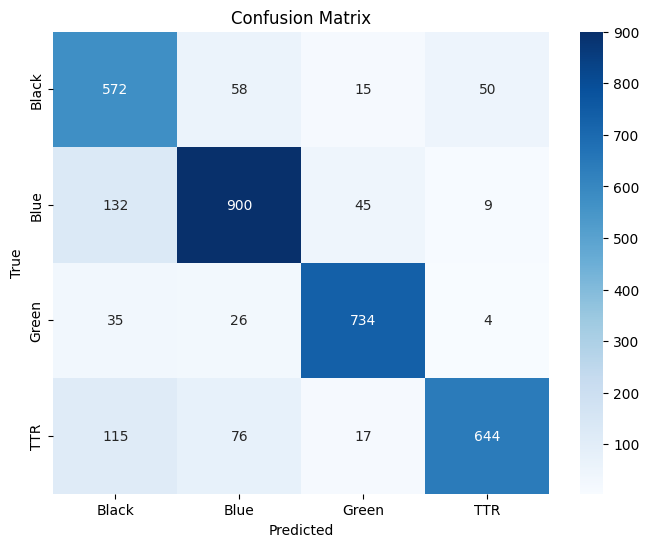


--- Incorrect Classifications Analysis ---


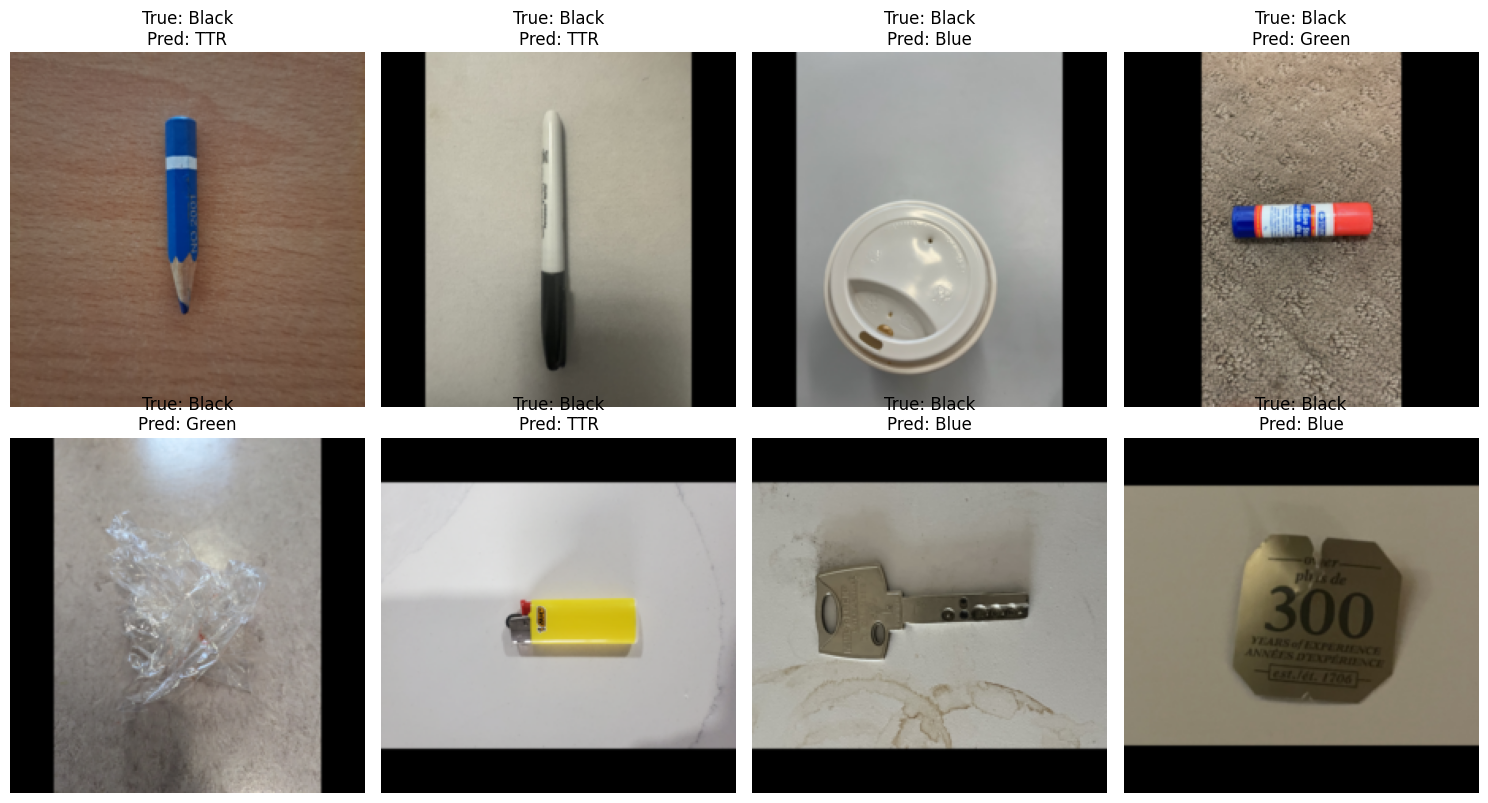

In [4]:
def run_evaluation():
    # Load Model
    model = MultimodalClassifier(num_classes=4).to(device)
    model.load_state_dict(torch.load(model_path, map_location=device))
    model.eval()

    # Load Data
    test_dataset = GarbageMultimodalDataset(base_path, split='Test', transform=test_transform)
    test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

    all_preds, all_labels = [], []
    incorrect_samples = []

    with torch.no_grad():
        for batch in test_loader:
            images = batch['image'].to(device)
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['label'].to(device)

            outputs = model(images, input_ids, attention_mask)
            _, predicted = torch.max(outputs, 1)
            
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            
            # Record incorrect cases for visualization
            mask = predicted != labels
            if mask.any():
                # We save the image, the true label, and the prediction
                for i in range(len(mask)):
                    if mask[i] and len(incorrect_samples) < 8: # Just keep first 8 errors
                        incorrect_samples.append({
                            'img': images[i].cpu(),
                            'label': labels[i].cpu().item(),
                            'pred': predicted[i].cpu().item()
                        })

    # Print Classification Report
    print("\n--- Final Classification Report ---")
    print(classification_report(all_labels, all_preds, target_names=test_dataset.classes))

    # Plot Confusion Matrix
    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=test_dataset.classes, yticklabels=test_dataset.classes)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

    # Show Incorrect Classifications
    print("\n--- Incorrect Classifications Analysis ---")
    plt.figure(figsize=(15, 8))
    for i, sample in enumerate(incorrect_samples):
        plt.subplot(2, 4, i + 1)
        # Unnormalize image for display
        img = sample['img'].permute(1, 2, 0).numpy()
        img = np.clip(img * [0.229, 0.224, 0.225] + [0.485, 0.456, 0.406], 0, 1)
        plt.imshow(img)
        plt.title(f"True: {test_dataset.classes[sample['label']]}\nPred: {test_dataset.classes[sample['pred']]}")
        plt.axis('off')
    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    run_evaluation()